## C_l sampler initial notes and tests

In [269]:
import os
import glob
import sys

import numpy as np
import healpy as hp

from scipy import signal
from scipy.fftpack import fft, fft2, fftshift, fftfreq
from scipy import integrate
from scipy.stats import invgamma, norm

from pygdsm import GlobalSkyModel16
from pygdsm import GlobalSkyModel

import re

# Plotting
#import matplotlib.pyplot as plt
import cmocean
import cmocean.cm as cmo
import seaborn as sns
import pylab as plt
import matplotlib as mpl
import matplotlib.pyplot as pyplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from matplotlib import ticker
# tango colors for colorpairs
sys.path.append("/Users/user/Documents/hera/tango-colors")
# from tango_colors import Tango
# tango = Tango('HTML')
import corner


# HYDRA (for HERA antennas)
sys.path.append("/Users/user/Documents/hera/Hydra") # change this to your own path
import hydra
from hydra.utils import build_hex_array

In [2]:
plt.rcParams['font.size'] = '18'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.titlepad'] = 16
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
plt.rcParams["errorbar.capsize"] = 5

# Function definitions

## Mode conversion functions

### `healpy2alms`

In [3]:
def healpy2alms(healpy_modes):
    """
    Takes a complex array of alms (positive modes only) and turns into
    a real array split as [real, imag] making sure to remove the 
    m=0 modes from the imag-part.
      
     Parameters
    ----------
    * healpy_modes (ndarray (complex)):
            Array of zeros except for the specified mode. 
            The array represents all positive (+m) modes including zeroth modes.
    
    Returns
    -------
    * alms (ndarray (floats))
            Array of zeros except for the specified mode. 
            The array represents all positive (+m) modes including zero 
            and is split into a real (first) and imag (second) part. The
            Imag part is smaller as the m=0 modes shouldn't contain and 
            imaginary part. 
    """
    lmax = hp.sphtfunc.Alm.getlmax(healpy_modes.size) # to remove the m=0 imag modes
    alms = np.concatenate((healpy_modes.real,healpy_modes.imag[(lmax+1):]))
        
    return alms    


### `alms2healpy`

In [4]:
def alms2healpy(alms, lmax):
    """
    Takes a real array split as [real, imag] (without the m=0 modes 
    imag-part) and turns it into a complex array of alms (positive 
    modes only) ordered as in HEALpy.
      
     Parameters
    ----------
    * alms (ndarray (floats))
            The array represents all positive (+m) modes including zero 
            and has double length, as real and imaginary values are split. 
            The first half is the real values.

    
    Returns
    -------
    * healpy_modes (ndarray (complex)):
            Array of zeros except for the specified mode. 
            The array represents all positive (+m) modes including zeroth modes.
            
    """
    
    real_imag_split_index = int((np.size(alms)+(lmax+1))/2)
    real = alms[:real_imag_split_index]
    
    add_imag_m0_modes = np.zeros(lmax+1)
    imag = np.concatenate((add_imag_m0_modes, alms[real_imag_split_index:]))
    
    healpy_modes = real + 1.j*imag
    
    return healpy_modes

### `lm_order_alms`

In [5]:
def lm_order_alms(alms, lmax):
    """
    Takes a real array split as [real, imag] (without the m=0 modes 
    imag-part) ordered as (m,l) and reorders as (l,m) (still omitting
    the m=0 imaginary modes)
      
     Parameters
    ----------
    * alms (ndarray (floats))
            The array represents all positive (+m) modes including zero 
            and has double length, as real and imaginary values are split. 
            The first half is the real values.

    * lmax (integer)
            The maximum ell-value 

    
    Returns
    -------
    * healpy_modes (ndarray (complex)):
            Array of zeros except for the specified mode. 
            The array represents all positive (+m) modes including zeroth modes.
            
    """
    
    healpy_modes = alms2healpy(alms,lmax)

    # intialise for-loop
    real_modes = np.zeros_like(healpy_modes.real)
    imag_modes = np.zeros_like(healpy_modes.imag[(lmax+1):])
    real_idx = 0
    imag_idx = 0
    
    for ell in np.arange(0,lmax+1):
        for em in np.arange(0,ell+1): 
            healpy_idx = hp.sphtfunc.Alm.getidx(lmax, ell, em)
            real_modes[real_idx] = healpy_modes[healpy_idx].real
            real_idx +=1
            
            if em != 0:
                imag_modes[imag_idx] = healpy_modes[healpy_idx].imag
                imag_idx +=1

    return np.concatenate((real_modes, imag_modes))


### `get_em_ell_idx`

In [6]:
def get_em_ell_idx(lmax):
    """
    Function to get the em, ell, and index of all the modes given the lmax. 
    (m,l)-ordering, (m-major ordering)

    Parameters
    ----------
    * lmax: (int)
        Maximum ell value for alms

    Returns
    -------
    * ems: (list (int))
        List of all the em values of the alms (m,l)-ordering (m-major)

    * ells: (list (int))
        List of all the ell values of the alms (m,l)-ordering (m-major)
        
    * idx: (list (int)) 
        List of all the indices for the alms

    """

    ells_list = np.arange(0,lmax+1)
    em_real = np.arange(0,lmax+1)
    em_imag = np.arange(1,lmax+1)
    
    Nreal = 0
    i = 0
    idx = []
    ems = []
    ells = []

    for em in em_real:
        for ell in ells_list:
            if ell >= em:
                idx.append(i)
                ems.append(em)
                ells.append(ell)
                
                Nreal += 1
                i +=1
    
    Nimag=0

    for em in em_imag:
        for ell in ells_list:
            if ell >= em:
                idx.append(i)
                ems.append(em)
                ells.append(ell)

                Nimag += 1
                i += 1

    return ems, ells, idx

### `find_common_true_index`

In [7]:
def find_common_true_index(arr_em, arr_ell, lmax):
    """
    Find the common index between two arrays of same length consisting of true and false.

    Parameters
    ----------
    * arr_em: (ndarray (boolean))
        The m array to compare, consisting of true and false

    * arr_ell: (ndarray (boolean))
        The ell array to compare, consisting of true and false

    Returns
    -------
    * idx_real: (int)
        The common index for the real part

    * idx_imag: (int)
        The common index for the imag part

    """
    real_imag_split_index = int(((lmax+1)**2 + (lmax+1))/2)

    real_idx = []
    imag_idx = []

    for idx in range(len(arr_em)):
        if arr_em[idx] and arr_ell[idx] and idx < real_imag_split_index:
            real_idx = idx
        elif arr_em[idx] and arr_ell[idx] and idx >= real_imag_split_index:
            imag_idx = idx

    return real_idx, imag_idx


### `get_idx_ml`

In [8]:
def get_idx_ml(em, ell, lmax):
    """
    Get the global index for the alms (m,l)-ordering (m-major) given a m 
    and ell value. 
    
    Parameters
    ----------
    * em: (int)
        The em value of the mode. Note, em cannot be greater than the ell value.

    * ell: (int)
        The ell value of the mode. Note, ell has to be larger or equal to the em value.

    * lmax: (int)
        The lmax of the modes

    Returns
    -------
    * common_idx_real: (int)
        The global index of the real part of the spherical harmonic mode

    * common_idx_imag: (int)
        The global index of the imaginary part of the spherical harmonic mode. 
        There are no m=0 imaginary mode, so in case of m=0 it returns and empty list [].

    """

    assert np.all(em <= ell), "m cannot be greater than the ell value"
    ems_idx, ells_idx, idx = get_em_ell_idx(lmax)

    em_check = np.array(ems_idx) == em
    ell_check = np.array(ells_idx) == ell

    common_idx_real, common_idx_imag = find_common_true_index(arr_em=em_check,
                                                              arr_ell=ell_check,
                                                              lmax=lmax)
    if common_idx_imag == []:
        idx_list = [common_idx_real]
    else:
        idx_list = [common_idx_real, common_idx_imag]
        
    for common_idx in idx_list:
        assert common_idx == idx[common_idx], "the global index does not match the index list"
        assert em == ems_idx[common_idx], "The em corresponding to the global index does not match the chosen em"
        assert ell == ells_idx[common_idx], "The ell corresponding to the global index does not match the vhosen ell"

    return common_idx_real, common_idx_imag

### `get_em_labels`

In [9]:
def get_em_labels(lmax):
    ells = np.arange(0,lmax+1)
    em_real = np.arange(0,lmax+1) 
    em_imag = np.arange(1,lmax+1)

    # ylabel = []
    # First append all real (l,m) values
    Nreal = 0
    i = 0
    idx = []
    ems = []
    for em in em_real:
        for ell in ells:
            if ell >= em:
                # ylabel.append((ell, em))
                if ell == em:
                    idx.append(i)
                    if ell == 0:
                        ems.append(fr'$m= {em}$')
                    else:
                        ems.append(fr'${em}$')
                Nreal += 1
                i += 1

    # Then all imaginary -- note: no m=0 modes!  
    Nimag = 0
    for em in em_imag:
        for ell in ells:
            if ell >= em:
                # ylabel.append((ell,em))
                if ell == em:
                    idx.append(i)
                    ems.append(fr'${em}$')
                Nimag += 1
                i += 1
    return ems, idx

### `get_healpy_from_gsm`

In [10]:
def get_healpy_from_gsm(freq, lmax, nside=64, resolution="low", output_model=False, output_map=False):
    """
    Generate an array of alms (HEALpy ordered) from gsm 2016 (https://github.com/telegraphic/pygdsm)
    
    Parameters
    ----------
    * freqs: (float or np.array)
        Frequency (in MHz) for which to return GSM model
        
    * lmax: (int)
        Maximum l value for alms
        
    * nside: (int)
        The NSIDE you want to upgrade/downgrade the map to. Default is nside=64.

    * resolution: (str)
        if "low/lo/l":  The GSM nside = 64  (default)
        if "hi/high/h": The GSM nside = 1024 

    * output_model: (Boolean) optional
        If output_model=True: Outputs model generated from the GSM data. 
        If output_model=False (default): no model output.

    * output_map: (Boolean) optional
        If output_map=True: Outputs map generated from the GSM data. 
        If output_map=False (default): no map output.

    Returns
    -------
    *healpy_modes: (np.array)
        Complex array of alms with same size and ordering as in healpy (m,l)
    
    *gsm_2016: (PyGDSM 2016 model) optional
        If output_model=True: Outputs model generated from the GSM data. 
        If output_model=False (default): no model output.

    *gsm_map: (healpy map) optional
        If output_map=True: Outputs map generated from the GSM data. 
        If output_map=False (default): no map output.
    
    """
    gsm_2016 = GlobalSkyModel16(freq_unit='MHz', resolution=resolution) 
    gsm_map = gsm_2016.generate(freqs=freq)
    gsm_upgrade = hp.ud_grade(gsm_map, nside)
    healpy_modes_gal = hp.map2alm(maps=gsm_upgrade,lmax=lmax)

    # Per default it is in gal-coordinates, convert to equatorial
    rot_gal2eq = hp.Rotator(coord="GC")
    healpy_modes_eq = rot_gal2eq.rotate_alm(healpy_modes_gal)

    if output_model == False and output_map == False: # default
        return healpy_modes_eq
    elif output_model == False and output_map == True:
        return healpy_modes_eq, gsm_map 
    elif output_model == True and output_map == False:
        return healpy_modes_eq, gsm_2016 
    else:
        return healpy_modes_eq, gsm_2016, gsm_map

## Plotting functions

### `discrete_cmap`

In [11]:
def discrete_cmap(N, base_cmap=None):
    """
    Create an N-bin discrete colormap from the specified input map

    Notes:
    
    If base_cmap is a string or None, you can simply do return plt.cm.get_cmap(base_cmap, N)
    The following works for string, None, or a colormap instance:
    """

    base = plt.colormaps.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    
    return base.from_list(cmap_name, color_list, N)

### `alm_plot`

In [12]:
def alm_plot(x_true, x_solns, lmax, title, filename, ylabel, xlabel, xlim=None, ylim=None, pdf=True, display = False):
    
    # Choose colours
    cmap20 = discrete_cmap(lmax,cmo.thermal)
    bgcolor = cmap20(16)
    linecolor = '0.5'
    
    # Convert to HEALpy alms for better intuition
    ells, ems = hp.sphtfunc.Alm.getlm(lmax)
    hp_true = alms2healpy(x_true,lmax)
    hp_solns = np.empty((x_solns.shape[0],hp_true.shape[0]),dtype=np.dtype(np.complex128))
    idx = 0
    for x_soln in x_solns:
        hp_soln = alms2healpy(x_soln,lmax)
        hp_solns[idx] = hp_soln
        idx += 1
        
    hp_soln_mean_real = np.mean(a=hp_solns.real, axis=0) 
    hp_soln_std_real = np.sqrt(np.var(a=hp_solns.real,axis=0))
    
    hp_soln_mean_imag = np.mean(a=hp_solns.imag, axis=0) 
    hp_soln_std_imag = np.sqrt(np.var(a=hp_solns.imag,axis=0))
    
    # Move points slightly to better see the different m-modes
    ell_em_labels = [float(ell) for ell in ells]
    em_idx = 0
    for em in ems:
        adjust = em/lmax*0.9
        ell_em_labels[em_idx] += adjust
        em_idx += 1
    
    ## PLOTTING SECTION
    fig, ax = plt.subplots(nrows=2, figsize=(16,6), sharex=True) 
    fig.subplots_adjust(hspace=0)
    
    for _ax in ax: 
        _ax.axhline(0,ls="-",color=linecolor, lw=2, alpha=0.5) 
        _ax.set_ylim([-109,109])
        _ax.set_xlim([-0.3,21.5])
        _ax.tick_params(length=6)

    # Plotting errorbars, marking out m=0 imag modes and outlier modes.
    outlier_ells_real = []
    ell_idx = 0
    for em in ems:
        # Real part
        diff_real = (hp_soln_mean_real-hp_true.real)[ell_idx]
        if diff_real > 100:
            real = ax[0].scatter(x=ell_em_labels[ell_idx], y=100, 
                                 marker='^', label='imag', color=cmap20(em))
            if np.any(np.isin(outlier_ells_real,ems[ell_idx])):
                ax[0].text(ell_em_labels[ell_idx]+0.2, 95, f'{diff_real:.0f}', va='center', rotation='horizontal')
            else: 
                ax[0].text(ell_em_labels[ell_idx]-0.3, 83, f'{diff_real:.0f}', va='center', rotation='horizontal')
                outlier_ells_real = np.append(outlier_ells_real,ells[ell_idx])
                        
        elif diff_real < -100:
            real = ax[0].scatter(x=ell_em_labels[ell_idx], y=-100, 
                                  marker='v', label='imag', color=cmap20(em))
            if np.any(np.isin(outlier_ells_real,ems[ell_idx])):
                ax[0].text(ell_em_labels[ell_idx]+0.2, -95, f'{diff_real:.0f}', va='center', rotation='horizontal')
            else: 
                ax[0].text(ell_em_labels[ell_idx]-0.3, -84, f'{diff_real:.0f}', va='center', rotation='horizontal')
                outlier_ells_real = np.append(outlier_ells_real,ells[ell_idx])
            
        else:
            real = ax[0].errorbar(x=ell_em_labels[ell_idx], y=diff_real, yerr=hp_soln_std_real[ell_idx], 
                                  fmt='o', label='real', color=cmap20(em))#,markerfacecolor=cmap20(em), markeredgecolor=bgcolor
                
        ## Imaginary. mark out the m=0 with an X
        diff_imag = (hp_soln_mean_imag-hp_true.imag)[ell_idx]
        if ems[ell_idx] == 0:
            imag = ax[1].scatter(x=ell_em_labels[ell_idx], y=diff_imag, 
              marker='x', label='imag', color=cmap20(em))#, color='white')#, markeredgecolor=cmap20(em))
        elif diff_imag > 100:
            imag = ax[1].scatter(x=ell_em_labels[ell_idx], y=100, 
                                 marker='^', label='imag', color=cmap20(em))
            ax[1].text(ell_em_labels[ell_idx]-0.4, 83, f'{diff_imag:.0f}', va='center', rotation='horizontal')
        elif diff_imag < -100:
            imag = ax[1].scatter(x=ell_em_labels[ell_idx], y=-100, 
                                  marker='v', label='imag', color=cmap20(em))
            ax[1].text(ell_em_labels[ell_idx]-0.4, -84, f'{diff_imag:.0f}', va='center', rotation='horizontal')
        else:
            imag = ax[1].errorbar(x=ell_em_labels[ell_idx], y=diff_imag, yerr=hp_soln_std_imag[ell_idx], 
                          fmt='o', label='imag', color=cmap20(em))#, markerfacecolor=cmap20(em), markeredgecolor=bgcolor)
        
        ell_idx+=1
        
    # customising ticks
    ax[0].tick_params(bottom=True, direction='inout')
    ax[1].tick_params(top=True, direction='inout')

    ax[0].tick_params(left=True, direction='out')
    ax[1].tick_params(left=True, direction='out')
    
    # Plot labels "real" or "imag"
    ax[0].text(20,-70,r'real', 
         bbox=dict(boxstyle="round",
                      fc=bgcolor, 
                      ec=None, 
                      lw=0, 
                      alpha=0.1))
    
    ax[1].text(19.8,-70,r'imag', 
         bbox=dict(boxstyle="round",
                  fc=bgcolor, 
                  ec=None, 
                  lw=0, 
                  alpha=0.1))
    
    # custom colorbar for m-values
    cax = fig.add_axes([0.585, 0.835, 0.3, 0.02]) #left, bottom, width, height
    norm = mpl.colors.Normalize(vmin=0, vmax=lmax)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap20,
                                    norm=norm,
                                    orientation='horizontal')
    cbar.set_label(r'$m$-value')
    
    # title and labels
    ax[0].set_title(title)
    ax[1].set_xlabel(xlabel, labelpad=8)
    fig.text(0.06, 0.5, ylabel, va='center', rotation='vertical')
    ax[1].set_xticks(np.arange(0,lmax+1,1)) # set xticks and labels to be integer and stop at lmax
    
    if pdf:
        filetype = '.pdf'
    else:
        filetype = '.png'
    # ax[0].yscale('log')
    plt.savefig(figpath+filename+filetype,
            bbox_inches='tight',
            transparent=False,
            dpi=300)#fig.dpi)

    if display == False:
        plt.close()

    return hp_soln_std_real, hp_soln_std_imag

# Main

In [64]:
# Display available folders
parentpath = '/Users/user/Documents/hera/cl_sampler_analysis/data/'
# [file[52:] for file in sorted(glob.glob(parentpath+'*'))]

x_true at idx=8 is -3.1624761020341596
x_true at idx=8 is -3.1624761020341596
x_true at idx=8 is -3.1624761020341596
x_true at idx=8 is -3.1624761020341596


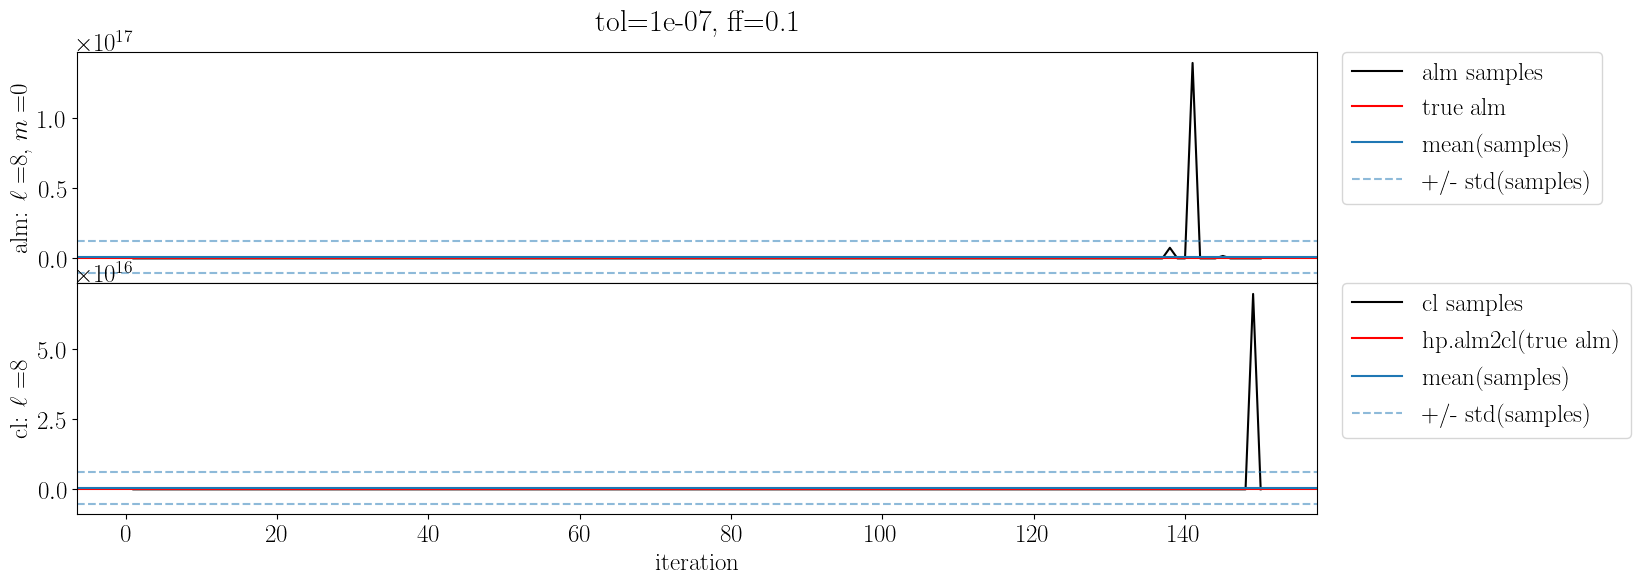

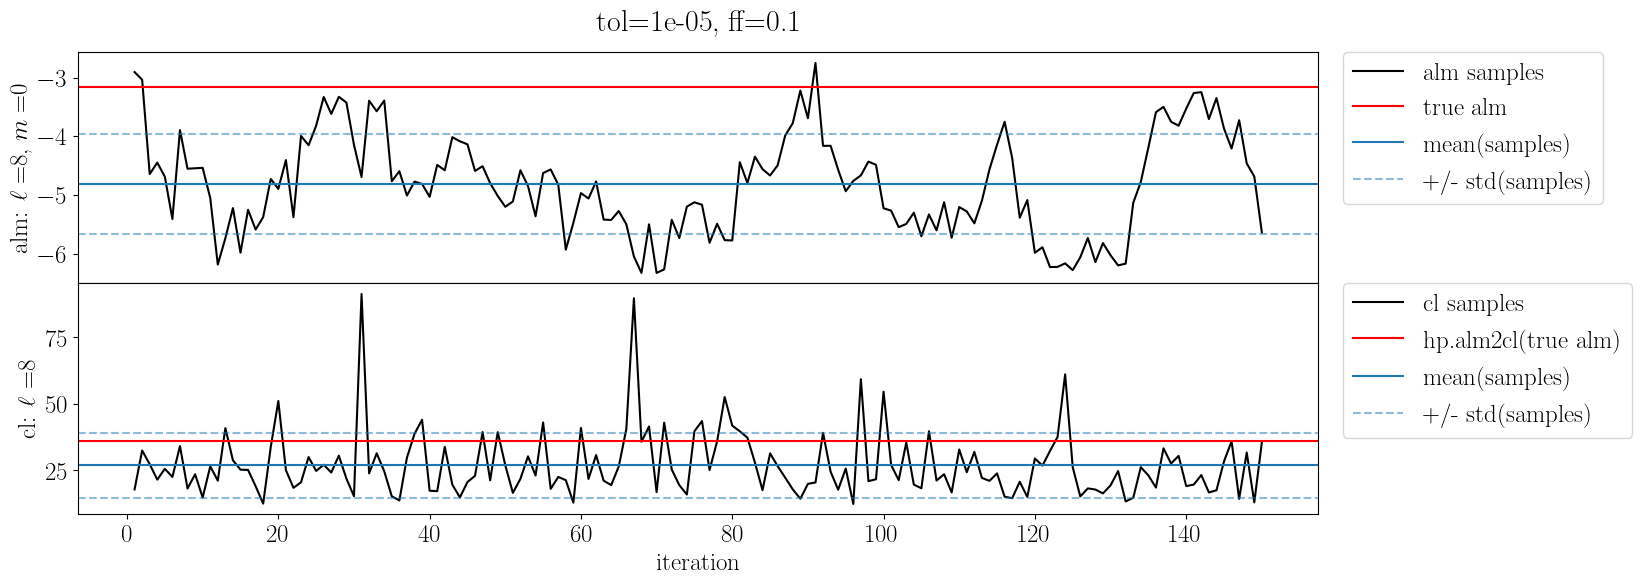

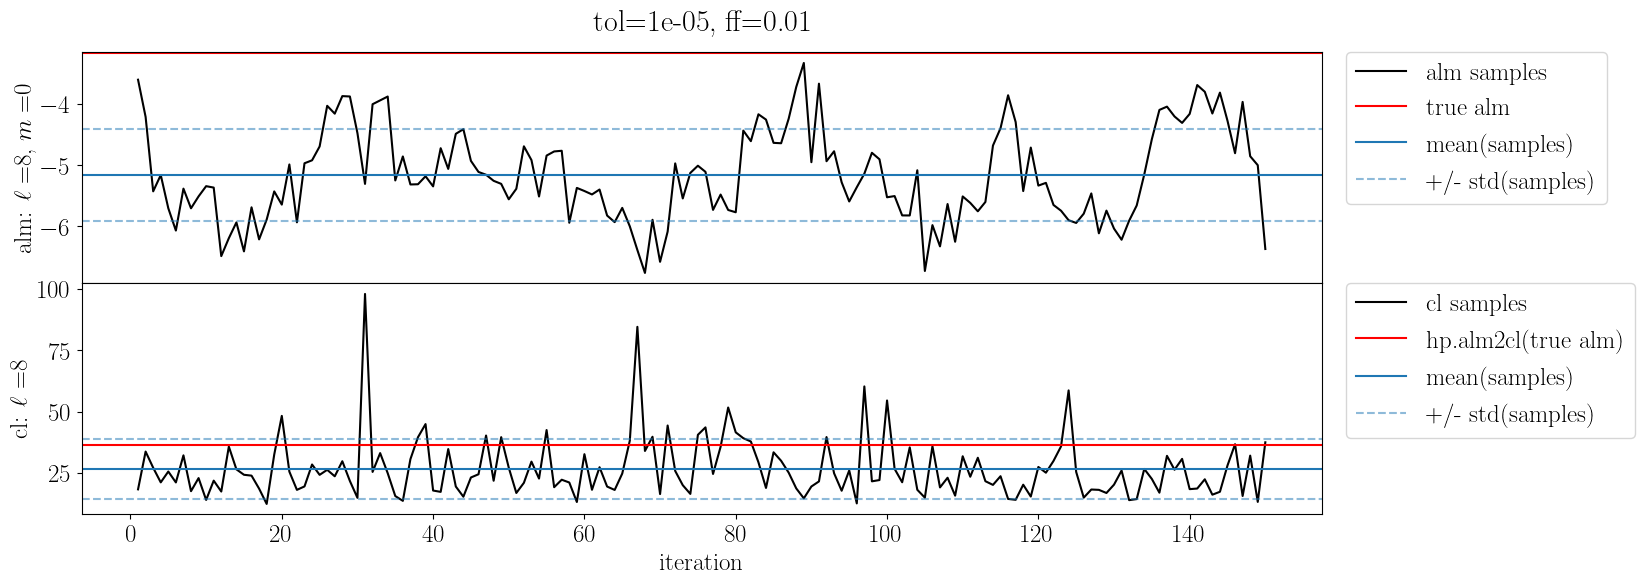

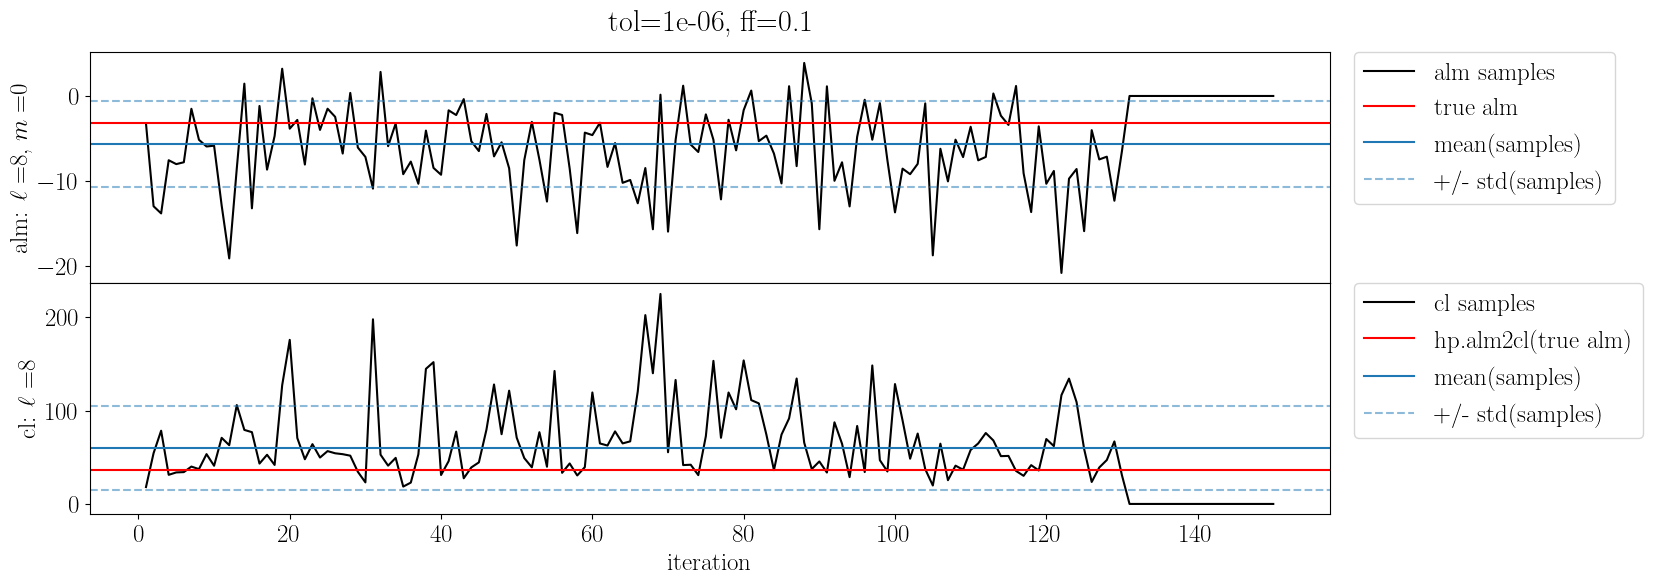

In [610]:
figpath = parentpath+'16-10-24_trace_plots/'
if not os.path.isdir(figpath): os.makedirs(figpath)

# Function to extract the number from the filename to correctly sort
def extract_number(filename):
    match = re.search(r'(\d+)\.npz$', filename)
    return int(match.group(1)) if match else 0

ell_mode = 8
em_mode = 0

folders = ['400MHz_1m','tol_05_ff_01', 'tol_05_ff_001', 'tol_06_ff_01']
title = ['tol=1e-07, ff=0.1','tol=1e-05, ff=0.1', 'tol=1e-05, ff=0.01', 'tol=1e-06, ff=0.1']

for num, folder in enumerate(folders):

    # folder = f'{frequency}MHz_1m/'
    # path = parentpath+'10-10-24_tol_broad/'+folder
    path = parentpath+folder+'/'


    # Precomputation for automatic lmax
    precomp = np.load(path+'precomputed_data_20_1.npz')
    lmax = precomp['lmax']
    real_idx, imag_idx = get_idx_ml(em=em_mode, ell=ell_mode, lmax=lmax)

    #true sky
    x_true = precomp['x_true']
    print(f'x_true at idx={real_idx} is {x_true[real_idx]}')
    cl_true_hp = hp.alm2cl(alms2healpy(x_true,lmax))

    # Get file lists
    alm_file_list = sorted(glob.glob(path+'alms_*'), key=extract_number)
    cl_file_list = sorted(glob.glob(path+'cls_*'), key=extract_number)
    
    fig, ax = plt.subplots(nrows=2, figsize=(16,6), sharex=True) 
    fig.subplots_adjust(hspace=0)

    
    # allocate arrays
    x_solns = np.empty(150)#np.empty((len(alm_file_list)))
    cl_samples = np.empty(150)#np.empty((len(cl_file_list)))
    
    # Load alm results and assign
    for key, filename in enumerate(alm_file_list):
        if key < 150:
            result = np.load(filename)
            x_solns[key] = result['x_soln'][real_idx]
        else:
            break

    ax[0].plot(np.arange(1,151), x_solns, 'k', label='alm samples')
    # ax[0].plot(np.arange(1,len(alm_file_list)+1), x_solns, 'k', label='alm samples')
    ax[0].axhline(x_true[real_idx], label='true alm',color='red')
    # ax[0].plot(np.arange(1,len(alm_file_list)+1),
    #            np.cumsum(x_solns)/np.arange(1,len(alm_file_list)+1),
    #            label='cummu. mean')
    ax[0].axhline(np.mean(x_solns), label='mean(samples)')
    ax[0].axhline(np.mean(x_solns)+np.std(x_solns), ls='--', alpha=0.5, label='+/- std(samples)')
    ax[0].axhline(np.mean(x_solns)-np.std(x_solns), ls='--', alpha=0.5)
    
    # same for cls 
    for key, filename in enumerate(cl_file_list):
        if key < 150:
            result = np.load(filename)
            cl_samples[key] = result['cl_samples'][ell_mode]
        else:
            break

    ax[1].plot(np.arange(1,151), cl_samples, 'k', label='cl samples')
    # ax[1].plot(np.arange(1,len(cl_file_list)+1), cl_samples, 'k', label='cl samples')
    ax[1].axhline(cl_true_hp[ell_mode], color='red', label='hp.alm2cl(true alm)')
    ax[1].axhline(np.mean(cl_samples), label='mean(samples)')
    ax[1].axhline(np.mean(cl_samples)+np.std(cl_samples), ls='--', alpha=0.5, label='+/- std(samples)')
    ax[1].axhline(np.mean(cl_samples)-np.std(cl_samples), ls='--', alpha=0.5)
    # ax[1].plot(np.arange(1,len(cl_file_list)+1),
    #            np.cumsum(cl_samples)/np.arange(1,len(cl_file_list)+1),
    #           label='cummu. mean')

    # ax[0].set_ylim([-1.4,-1.25])
    
    # for axs in ax: axs.set_xlim([0, np.array([len(alm_file_list), 
                                              # len(cl_file_list)]).max()])

    ax[0].set_ylabel(r'alm: $\ell=$'+f'{ell_mode}, '+r'$m=$'+f'{em_mode}')
    ax[1].set_ylabel(r'cl: $\ell=$'+f'{ell_mode}')

    ax[1].set_xlabel('iteration')

    ax[0].set_title(title[num])

    ax[0].legend(bbox_to_anchor=(1.02, 1), borderaxespad=0)
    ax[1].legend(bbox_to_anchor=(1.02, 1), borderaxespad=0)

    
    # Save final figure
    fig.savefig(figpath+f'trace_'+title[num]+'.png', 
        bbox_inches='tight', 
        transparent=True, 
        dpi=200,
        facecolor='white')

    # plt.close()
    


x_true at idx=8 is -3.1624761020341596
x_true at idx=8 is -3.1624761020341596
x_true at idx=8 is -3.1624761020341596
x_true at idx=8 is -3.1624761020341596


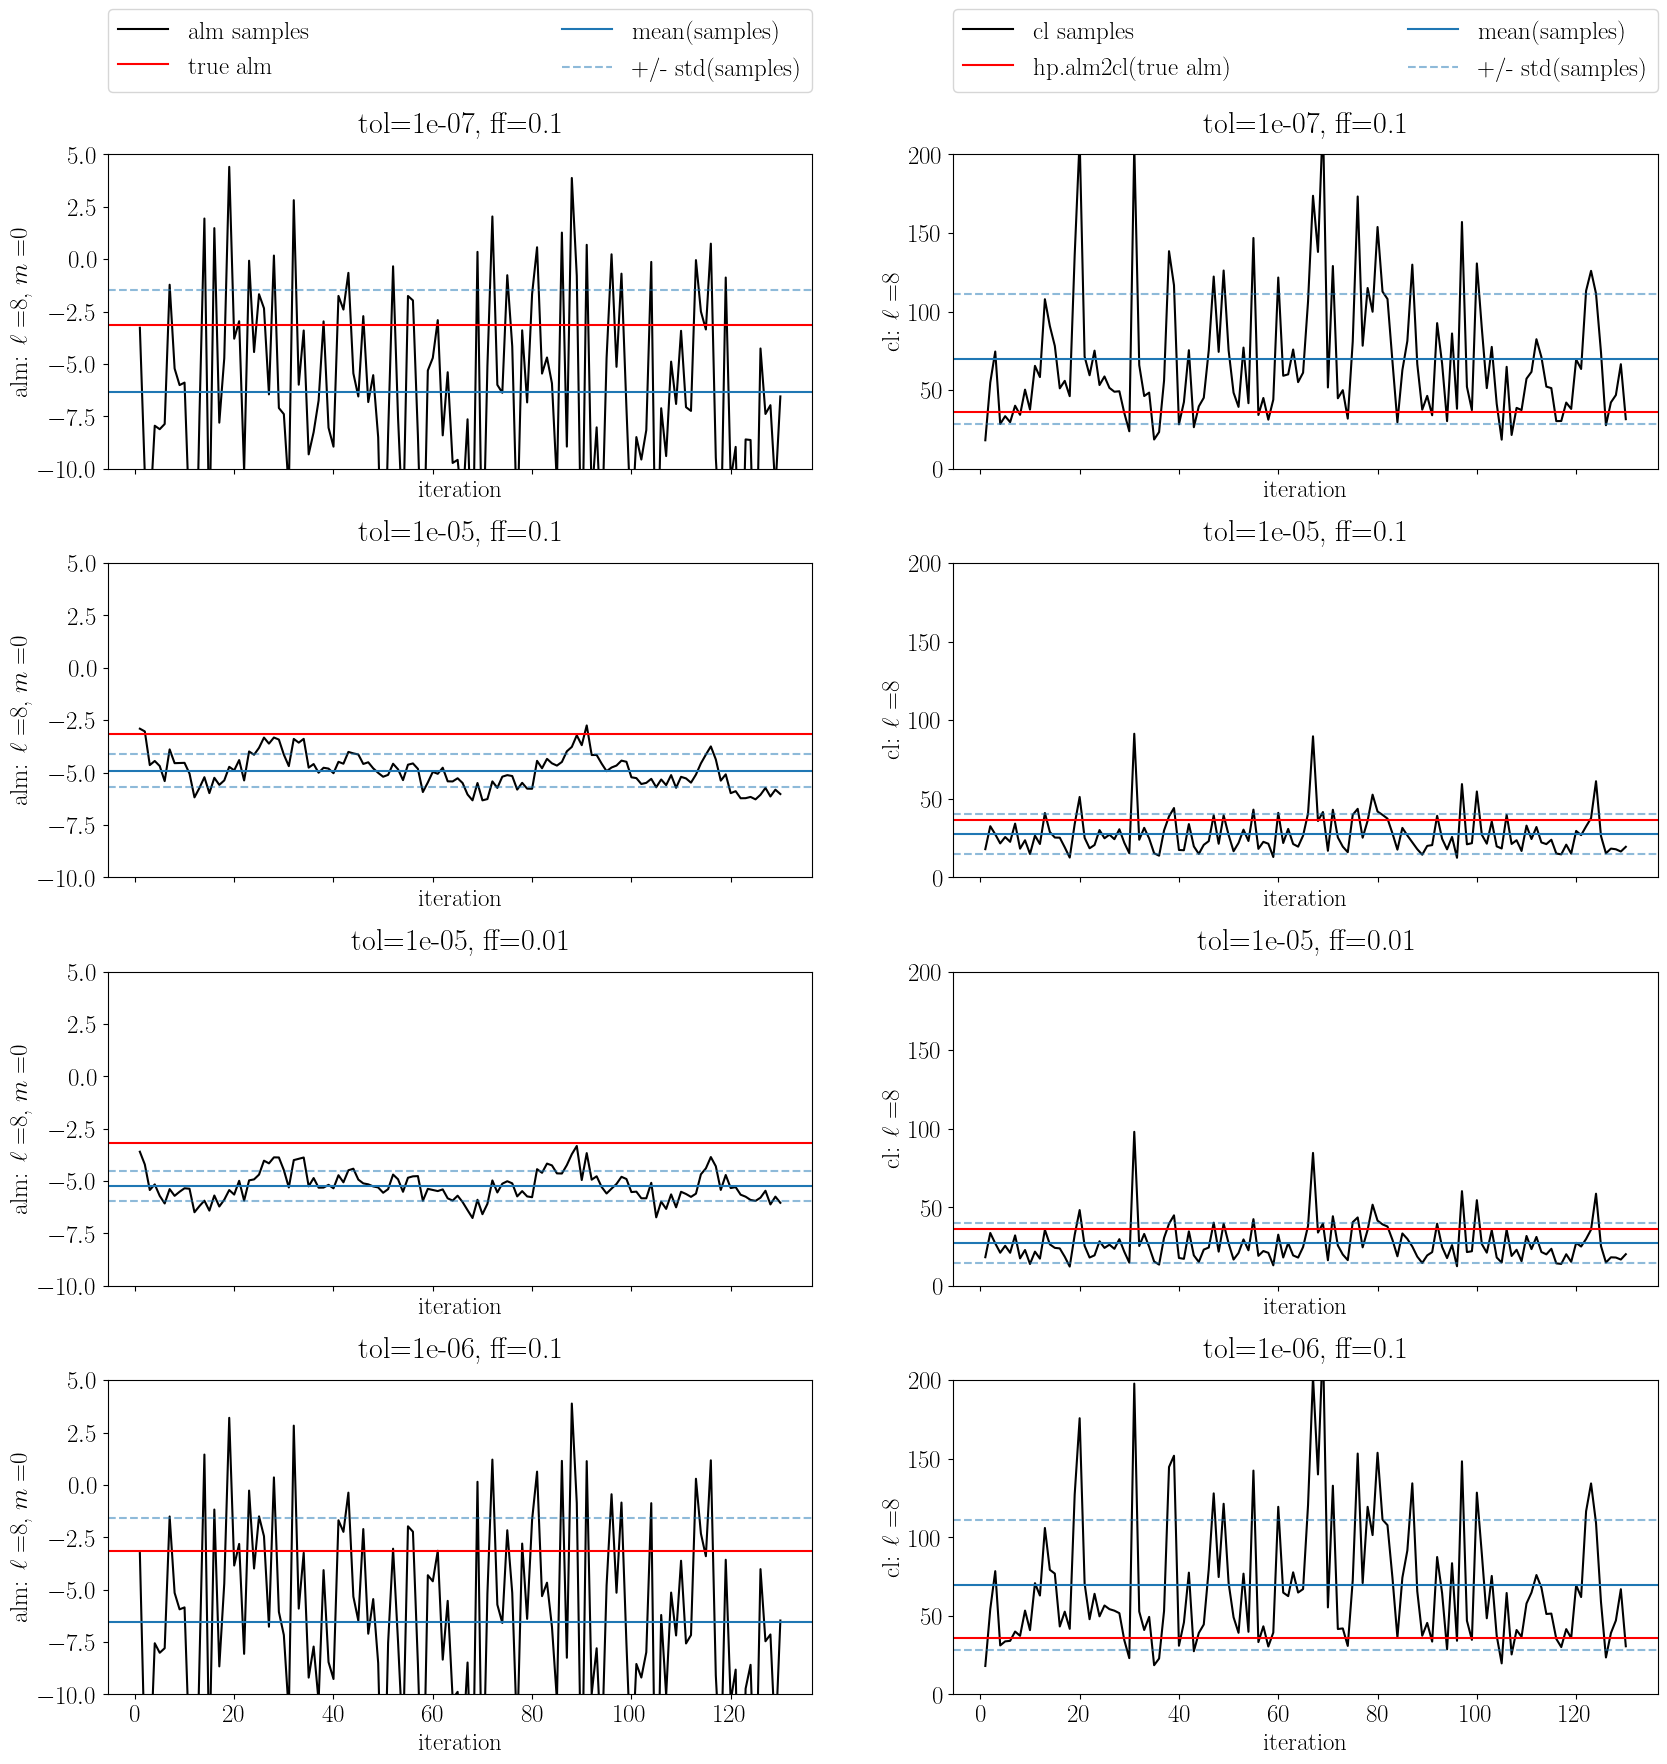

In [642]:
fig, ax = plt.subplots(nrows=len(folders),ncols=2, figsize=(20,20), sharex=True) 
fig.subplots_adjust(hspace=0.3)

niter = 130


for num, folder in enumerate(folders):

    # folder = f'{frequency}MHz_1m/'
    # path = parentpath+'10-10-24_tol_broad/'+folder
    path = parentpath+folder+'/'


    # Precomputation for automatic lmax
    precomp = np.load(path+'precomputed_data_20_1.npz')
    lmax = precomp['lmax']
    real_idx, imag_idx = get_idx_ml(em=em_mode, ell=ell_mode, lmax=lmax)

    #true sky
    x_true = precomp['x_true']
    print(f'x_true at idx={real_idx} is {x_true[real_idx]}')
    cl_true_hp = hp.alm2cl(alms2healpy(x_true,lmax))

    # Get file lists
    alm_file_list = sorted(glob.glob(path+'alms_*'), key=extract_number)
    cl_file_list = sorted(glob.glob(path+'cls_*'), key=extract_number)
    
    # allocate arrays
    x_solns = np.zeros(niter)#np.empty((len(alm_file_list)))
    cl_samples = np.zeros(niter)#np.empty((len(cl_file_list)))
    
    # Load alm results and assign
    for key, filename in enumerate(alm_file_list):
        if key < niter:
            result = np.load(filename)
            x_solns[key] = result['x_soln'][real_idx]
        else:
            break

    ax[num,0].plot(np.arange(1,niter+1), x_solns, 'k', label='alm samples')
    # ax[0].plot(np.arange(1,len(alm_file_list)+1), x_solns, 'k', label='alm samples')
    ax[num,0].axhline(x_true[real_idx], label='true alm',color='red')
    # ax[0].plot(np.arange(1,len(alm_file_list)+1),
    #            np.cumsum(x_solns)/np.arange(1,len(alm_file_list)+1),
    #            label='cummu. mean')
    ax[num,0].axhline(np.mean(x_solns), label='mean(samples)')
    ax[num,0].axhline(np.mean(x_solns)+np.std(x_solns), ls='--', alpha=0.5, label='+/- std(samples)')
    ax[num,0].axhline(np.mean(x_solns)-np.std(x_solns), ls='--', alpha=0.5)
    
    # same for cls 
    for key, filename in enumerate(cl_file_list):
        if key < niter:
            result = np.load(filename)
            cl_samples[key] = result['cl_samples'][ell_mode]
        else:
            break

    ax[num,1].plot(np.arange(1,niter+1), cl_samples, 'k', label='cl samples')
    # ax[1].plot(np.arange(1,len(cl_file_list)+1), cl_samples, 'k', label='cl samples')
    ax[num,1].axhline(cl_true_hp[ell_mode], color='red', label='hp.alm2cl(true alm)')
    ax[num,1].axhline(np.mean(cl_samples), label='mean(samples)')
    ax[num,1].axhline(np.mean(cl_samples)+np.std(cl_samples), ls='--', alpha=0.5, label='+/- std(samples)')
    ax[num,1].axhline(np.mean(cl_samples)-np.std(cl_samples), ls='--', alpha=0.5)
    # ax[1].plot(np.arange(1,len(cl_file_list)+1),
    #            np.cumsum(cl_samples)/np.arange(1,len(cl_file_list)+1),
    #           label='cummu. mean')

    # ax[0].set_ylim([-1.4,-1.25])
    
    # for axs in ax: axs.set_xlim([0, np.array([len(alm_file_list), 
                                              # len(cl_file_list)]).max()])

    ax[num,0].set_ylabel(r'alm: $\ell=$'+f'{ell_mode}, '+r'$m=$'+f'{em_mode}')
    ax[num,1].set_ylabel(r'cl: $\ell=$'+f'{ell_mode}')

    ax[num,0].set_xlabel('iteration')
    ax[num,1].set_xlabel('iteration')

    ax[num,0].set_title(title[num])
    ax[num,1].set_title(title[num])

    ax[num,0].set_ylim([-10,5])
    ax[num,1].set_ylim([0,200])

ax[0,0].legend(bbox_to_anchor=(0, 1.2, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
ax[0,1].legend(bbox_to_anchor=(0, 1.2, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

    
# Save final figure
fig.savefig(figpath+f'traces'+'.png', 
    bbox_inches='tight', 
    transparent=True, 
    dpi=200,
    facecolor='white')

# plt.close()
    


x_true at idx=49 is -0.13187911932336382
x_true at idx=49 is -0.13187911932336382
x_true at idx=49 is -0.13187911932336382
x_true at idx=49 is -0.13187911932336382


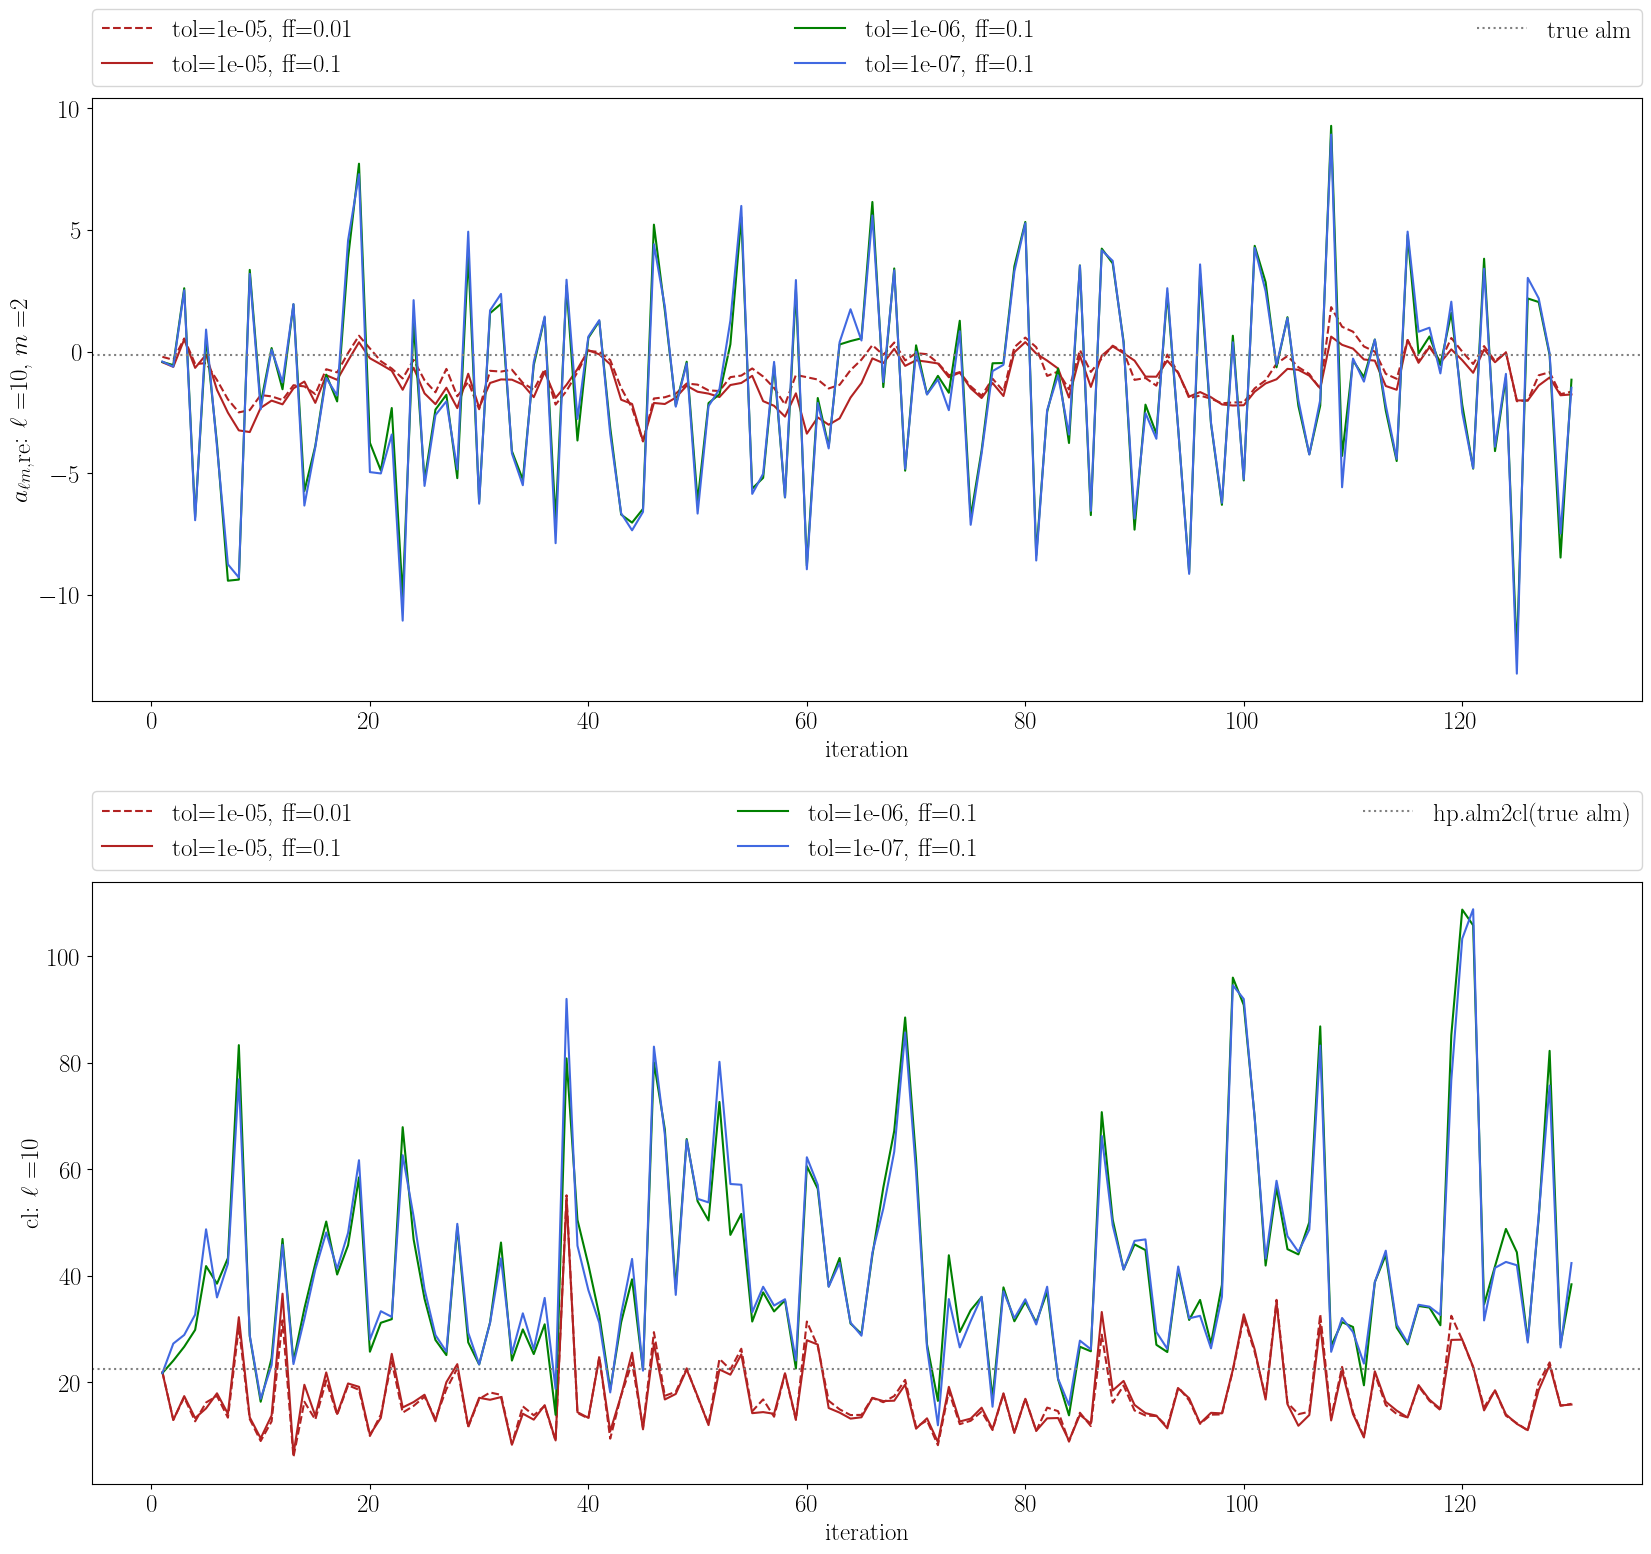

In [669]:
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20,18))#, sharex=True) 
fig.subplots_adjust(hspace=0.3)

em_mode = 2
ell_mode = 10

niter = 130

cmap4 = discrete_cmap(4, cmocean.tools.crop_by_percent(cmo.phase, 30, which='both', N=None))

folders = ['tol_05_ff_001', 'tol_05_ff_01', 'tol_06_ff_01','400MHz_1m']
title = ['tol=1e-05, ff=0.01', 'tol=1e-05, ff=0.1', 'tol=1e-06, ff=0.1', 'tol=1e-07, ff=0.1']
colors = ['firebrick', 'firebrick', 'green', 'royalblue']
ls = ['--', '-', '-', '-']

for num, folder in enumerate(folders):

    # folder = f'{frequency}MHz_1m/'
    # path = parentpath+'10-10-24_tol_broad/'+folder
    path = parentpath+folder+'/'


    # Precomputation for automatic lmax
    precomp = np.load(path+'precomputed_data_20_1.npz')
    lmax = precomp['lmax']
    real_idx, imag_idx = get_idx_ml(em=em_mode, ell=ell_mode, lmax=lmax)

    #true sky
    x_true = precomp['x_true']
    print(f'x_true at idx={real_idx} is {x_true[real_idx]}')
    cl_true_hp = hp.alm2cl(alms2healpy(x_true,lmax))

    # Get file lists
    alm_file_list = sorted(glob.glob(path+'alms_*'), key=extract_number)
    cl_file_list = sorted(glob.glob(path+'cls_*'), key=extract_number)
    
    # allocate arrays
    x_solns = np.zeros(niter)#np.empty((len(alm_file_list)))
    cl_samples = np.zeros(niter)#np.empty((len(cl_file_list)))
    
    # Load alm results and assign
    for key, filename in enumerate(alm_file_list):
        if key < niter:
            result = np.load(filename)
            x_solns[key] = result['x_soln'][real_idx]
        else:
            break



    ax[0].plot(np.arange(1,niter+1), x_solns, color=colors[num], ls=ls[num], label=title[num])
    # ax[0].plot(np.arange(1,len(alm_file_list)+1), x_solns, 'k', label='alm samples')

    if num == 3:
        ax[0].axhline(x_true[real_idx], label='true alm',color='grey', ls=':')

    # ax[0].plot(np.arange(1,len(alm_file_list)+1),
    #            np.cumsum(x_solns)/np.arange(1,len(alm_file_list)+1),
    #            label='cummu. mean')
    
    # ax[0].axhline(np.mean(x_solns), label='mean(samples)')
    # ax[0].axhline(np.mean(x_solns)+np.std(x_solns), ls='--', alpha=0.5, label='+/- std(samples)')
    # ax[0].axhline(np.mean(x_solns)-np.std(x_solns), ls='--', alpha=0.5)
    
    # same for cls 
    for key, filename in enumerate(cl_file_list):
        if key < niter:
            result = np.load(filename)
            cl_samples[key] = result['cl_samples'][ell_mode]
        else:
            break


    
    ax[1].plot(np.arange(1,niter+1), cl_samples, color=colors[num], ls=ls[num], label=title[num])
    # ax[1].plot(np.arange(1,len(cl_file_list)+1), cl_samples, 'k', label='cl samples')

    if num == 3:
        ax[1].axhline(cl_true_hp[ell_mode], color='grey', ls=':', label='hp.alm2cl(true alm)')

    # ax[1].axhline(np.mean(cl_samples), label='mean(samples)')
    # ax[1].axhline(np.mean(cl_samples)+np.std(cl_samples), ls='--', alpha=0.5, label='+/- std(samples)')
    # ax[1].axhline(np.mean(cl_samples)-np.std(cl_samples), ls='--', alpha=0.5)
    # ax[1].plot(np.arange(1,len(cl_file_list)+1),
    #            np.cumsum(cl_samples)/np.arange(1,len(cl_file_list)+1),
    #           label='cummu. mean')

    # ax[0].set_ylim([-1.4,-1.25])
    
    # for axs in ax: axs.set_xlim([0, np.array([len(alm_file_list), 
                                              # len(cl_file_list)]).max()])

    ax[0].set_ylabel(r'$a_{\ell m, \textup{re}}$: $\ell=$'+f'{ell_mode}, '+r'$m=$'+f'{em_mode}')
    ax[1].set_ylabel(r'cl: $\ell=$'+f'{ell_mode}')

    ax[0].set_xlabel('iteration')
    ax[1].set_xlabel('iteration')

    # ax[num,0].set_title(title[num])
    # ax[num,1].set_title(title[num])

    # ax[0].set_ylim([-10,5])
    # ax[1].set_ylim([0,200])

    # if num == 0:
    ax[0].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
    ax[1].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
            mode="expand", borderaxespad=0, ncol=3)

    
# Save final figure
fig.savefig(figpath+f'traces'+'.png', 
    bbox_inches='tight', 
    transparent=True, 
    dpi=200,
    facecolor='white')

# plt.close()
    


NpzFile '/Users/user/Documents/hera/cl_sampler_analysis/data/400MHz_1m/precomputed_data_20_1.npz' with keys: vis_response, autos, x_true, inv_noise_cov, min_prior_std...